In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
%matplotlib inline

# Model Creation

In [7]:
# Height and width refer to the size of the image
# Channels refers to the amount of color channels (red, green, blue)

image_dimensions = {'height':299, 'width':299, 'channels':3}

In [8]:
# Create a Classifier class

class Classifier:
    def __init__():
        self.model = 0
    
    def predict(self, x):
        return self.model.predict(x)
    
    def fit(self, x, y):
        return self.model.train_on_batch(x, y)
    
    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)
    
    def load(self, path):
        self.model.load_weights(path)

In [9]:
# Create a Deepfake Model class using the Classifier

class DeepfakeModel(Classifier):
    def __init__(self, learning_rate = 0.001):
        self.model = self.init_model()
        optimizer = Adam(lr = learning_rate)
        self.model.compile(optimizer = optimizer,
                           loss = 'binary_crossentropy',
                           metrics = ['accuracy'])
    
    def init_model(self): 
        xModel=tf.keras.applications.xception.Xception(weights='imagenet',include_top=False, pooling='avg', input_shape = (299, 299, 3))

        count = 0
        for layer in xModel.layers:
            layer.trainable = False
            count += 1
            if count == 36:
                break
        
        output = Dense(1, activation='softmax')(xModel.output)

        return Model(xModel.input, output)

# Model Training

In [10]:
# Instantiate a Deepfake model with pretrained weights
rgb = DeepfakeModel()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
83689472/83683744 [==============================] - 13s 0us/step


In [12]:
# Prepare image data

# Rescaling pixel values (between 1 and 255) to a range between 0 and 1
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # set validation split

# Instantiating generator to feed images through the network
train_generator = train_datagen.flow_from_directory(
    './Dataset/RGB/',
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    './Dataset/RGB/', # same directory as training data
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    subset='validation') # set as validation data

Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


In [13]:
# Checking class assignment
train_generator.class_indices

{'Deepfake': 0, 'Real': 1}

In [20]:
hist = rgb.model.fit_generator(
    train_generator,
    steps_per_epoch = 160,
    epochs = 10,
    validation_data = validation_generator,
    validation_steps = 40
)

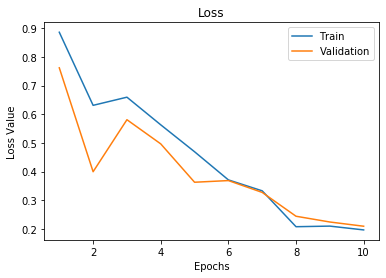

In [16]:
plt.plot(epoch, hist.train_loss, label = "Train")
plt.plot(epoch, hist.valid_loss, label = "Validation")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.legend()
plt.show()

In [19]:
rgb.model.save("Models/rgb_model.h5")

# Model Evaluation

In [17]:
model = load_model('Models/rgb_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
dataGenerator = ImageDataGenerator(rescale=1./255)

generator = dataGenerator.flow_from_directory(
    './Dataset/RGB/',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary')

Found 6000 images belonging to 2 classes.


(1, 256, 256, 3)
Predicted likelihood: 0.4930
Actual label: 0

Correct prediction: True


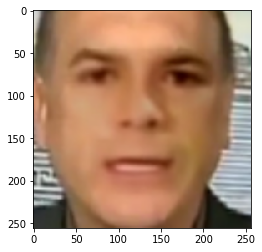

In [19]:
# Rendering image X with label y for MesoNet
X, y = generator.next()
print(X.shape)

# Evaluating prediction
print(f"Predicted likelihood: {model.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")
print(f"\nCorrect prediction: {round(model.predict(X)[0][0])==y[0]}")

# Showing image
plt.imshow(np.squeeze(X));

In [23]:
y_pred = []
y_act = []

# Generating predictions on validation set, storing in separate lists
for i in range(len(generator.labels)):
    
    # Loading next picture, generating prediction
    X, y = generator.next()
    pred = model.predict(X)[0][0]
    
    # Sorting into proper category
    if round(pred)==y[0] and y[0]==1:
        y_pred.append(1)
        y_act.append(1)
    elif round(pred)==y[0] and y[0]==0:
        y_pred.append(0)
        y_act.append(0)
    elif y[0]==1:
        y_pred.append(0)
        y_act.append(1)
    else:
        y_pred.append(1)
        y_act.append(0)
    
print("All predictions completed")
        
        

All predictions completed


In [40]:
print(classification_report(y_act, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      3000
           1       0.88      0.91      0.90      3000

    accuracy                           0.89      6000
   macro avg       0.89      0.89      0.89      6000
weighted avg       0.89      0.89      0.89      6000



In [41]:
cm = confusion_matrix(y_act, y_pred)
print(cm)

[[2622  378]
 [ 257 2743]]


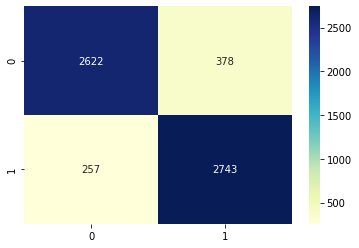

In [42]:
sns.heatmap(cm,annot=True,fmt="d",cmap="YlGnBu")

In [43]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]
            
accuracy = correct/sum(sum(cm))
print("Model Accuracy =", accuracy)

Model Accuracy = 0.8941666666666667
